In [1]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt
from Utils.MathUtils import *
from Utils.ImageUtils import *
from Utils.MiscUtils import *

In [2]:
def createCircularMask(image_size, radius, high_pass = True):
    rows, cols = image_size
    centre_x, centre_y = int(rows / 2), int(cols / 2)
    center = [centre_x, centre_y]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius*radius

    if high_pass:
        mask = np.ones((rows, cols)) 
        mask[mask_area] = 0
    else:
        mask = np.zeros((rows, cols)) 
        mask[mask_area] = 1

    return mask

In [3]:
def createGaussianMask(image_size, sigma_x, sigma_y):
    cols, rows = image_size
    centre_x, centre_y = rows / 2, cols / 2
    x = np.linspace(0, rows, rows)
    y = np.linspace(0, cols, cols)
    X, Y = np.meshgrid(x,y)
    mask = np.exp(-(np.square((X - centre_x)/sigma_x) + np.square((Y - centre_y)/sigma_y)))
    return mask

In [4]:
def blurImageUsingFFT(gray_image, SavePath):
    image_gray = gray_image.copy()
    #fft for blurring
    fft_blur = scipy.fft.fft2(image_gray, axes = (0,1))
    fft_shifted_blur = scipy.fft.fftshift(fft_blur)
    magnitude_spectrum_fft_shifted_blur = 20*np.log(np.abs(fft_shifted_blur))

    #fft+mask
    fft_masked_blur = fft_shifted_blur * createGaussianMask(image_gray.shape, 30, 30)
    magnitude_spectrum_masked_blur = 20*np.log(np.abs(fft_masked_blur))

    #image back
    img_back_blur = scipy.fft.ifftshift(fft_masked_blur)
    img_back_blur = scipy.fft.ifft2(img_back_blur)
    img_back_blur = np.abs(img_back_blur)

    fx, plts = plt.subplots(2,2,figsize = (15, 10))
    plts[0][0].imshow(image_gray, cmap = 'gray')
    plts[0][0].set_title('Gray Image')
    plts[0][1].imshow(magnitude_spectrum_fft_shifted_blur, cmap = 'gray')
    plts[0][1].set_title('FFT of Gray Image')
    plts[1][0].imshow(magnitude_spectrum_masked_blur, cmap = 'gray')
    plts[1][0].set_title('Mask + FFT of Gray Image')
    plts[1][1].imshow(img_back_blur, cmap = 'gray')
    plts[1][1].set_title('Blurred Image')
    plt.savefig(SavePath + "fft_blur" + ".jpg")

    return img_back_blur

In [11]:
def findEdgesUsingFFT(image, SavePath):
    thresh = image.copy()
    #fft
    fft_edges = scipy.fft.fft2(thresh, axes = (0,1))
    fft_shifted_edges = scipy.fft.fftshift(fft_edges)
    magnitude_spectrum_fft_shifted_edges = 20*np.log(np.abs(fft_shifted_edges))

    #fft+mask
    cmask = createCircularMask(thresh.shape, 15, True)
    fft_masked_edge = fft_shifted_edges * createCircularMask(thresh.shape, 100, True)
    magnitude_spectrum_masked_edge = 20*np.log(np.abs(fft_masked_edge))

    #image back
    img_back_edge = scipy.fft.ifftshift(fft_masked_edge)
    img_back_edge = scipy.fft.ifft2(img_back_edge)
    img_back_edge = np.abs(img_back_edge)

    fx, plts = plt.subplots(2,2,figsize = (15,10))
    plts[0][0].imshow(thresh, cmap = 'gray')
    plts[0][0].set_title('Gray Image')
    plts[0][1].imshow(magnitude_spectrum_fft_shifted_edges, cmap = 'gray')
    plts[0][1].set_title('FFT of Thresholded Image')
    plts[1][0].imshow(magnitude_spectrum_masked_edge, cmap = 'gray')
    plts[1][0].set_title('Mask + FFT of Thresholded Image')
    plts[1][1].imshow(img_back_edge, cmap = 'gray')
    plts[1][1].set_title('Edges of tag')
    plt.savefig(SavePath + "fft_edge"  + ".jpg")

    return img_back_edge


In [12]:
def detectARCode(image, SavePath):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_blur = blurImageUsingFFT(image_gray, SavePath)
    ret,thresh = cv2.threshold(np.uint8(image_blur), 200 ,255,cv2.THRESH_BINARY)
    image_edge = findEdgesUsingFFT(image_gray, SavePath)
    return image_blur, image_edge

In [66]:
def extractTagfromImage(img, SavePath):
    image = img.copy()
    tag_size = 160
    detected_april_tag = np.uint8(getTagMask(image, SavePath))
    corners = getTagCorners(detected_april_tag)
    cv2.drawContours(image, corners,0,(0,255,0),5)

    fx, plts = plt.subplots(1,2,figsize = (20,20))
    plts[0].imshow(detected_april_tag, cmap = 'gray')
    plts[0].set_title('Masked Image')
    plts[1].imshow(image)
    plts[1].set_title('Detected Tag')
    plt.savefig(SavePath + "tagDetection"  + ".jpg")

    detected_corners = sortCorners(corners[0])
    desired_tag_corner = sortCorners(np.array([ [0, tag_size-1], [tag_size-1, tag_size-1], [tag_size-1, 0], [0, 0]]))

    Htd = computeHomography(np.float32(detected_corners), np.float32(desired_tag_corner))
    tag = applyHomography2ImageUsingForwardWarping(image, Htd, (tag_size, tag_size))
    tag = cv2.cvtColor(np.uint8(tag), cv2.COLOR_BGR2GRAY)
    ret,tag = cv2.threshold(np.uint8(tag), 230 ,255,cv2.THRESH_BINARY)
    plt.figure()
    plt.imshow(tag, cmap = 'gray')
    plt.savefig(SavePath + "tag"  + ".jpg")
    return tag

In [67]:
def processRefTag(image):
    tag_size = 160
    ref_tag_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, ref_tag_image_bin = cv2.threshold(ref_tag_image_gray, 230 ,255,cv2.THRESH_BINARY)
    ref_tag_image_bin = cv2.resize(ref_tag_image_bin, (tag_size, tag_size))
    info = extractInfoFromTag(ref_tag_image_bin)
    tag_id, tag_id_bin = decipherInfoFromTag(info)
    print("The reference tag ID in binary is ", tag_id_bin)
    print("The reference tag ID is ", tag_id)

In [71]:
def main():
    BasePath = '/home/sakshi/courses/ENPM673/sakshi_p1/'
    SavePath = BasePath + "Results/problem1/"
    video_file = BasePath + "Data/Tag2.mp4"
    RefTagFileName = BasePath + "Data/ref_marker.png"
    ref_tag_image = cv2.imread(RefTagFileName)

    cap = cv2.VideoCapture(video_file)
    frame_index = 302
    tag_size = 160

    i = 0
    while(True):
        ret, frame = cap.read()
        if not ret:
            print("Stream ended..")
            break
        i = i + 1
        if i == frame_index:
            chosen_frame = frame
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    i = frame_index

    image = chosen_frame.copy()
    tag_blur, tag_edge = detectARCode(image, SavePath)

    # processRefTag(ref_tag_image)
    detected_april_tag = np.uint8(getTagMask(image, SavePath))

    tag = extractTagfromImage(image, SavePath)
    # info = extractInfoFromTag(tag)
    # tag_id, tag_id_bin = decipherInfoFromTag(info, SavePath)
    # print("The video tag ID in binary is ", tag_id_bin)
    # print("The video tag ID is ", tag_id)




In [72]:
if __name__ == '__main__':
    main()

Stream ended..


KeyboardInterrupt: 

The reference tag ID in binary is  [1, 1, 1, 1]
The reference tag ID is  15


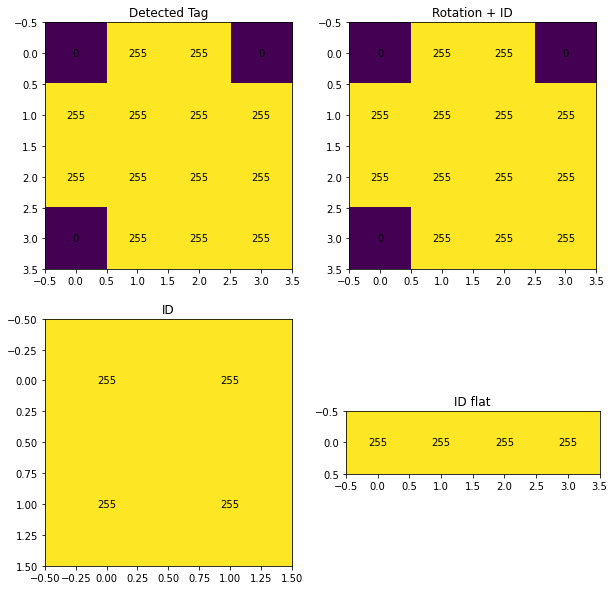

In [53]:
BasePath = '/home/sakshi/courses/ENPM673/sakshi_p1/'
RefTagFileName = BasePath + "Data/ref_marker.png"
ref_tag_image = cv2.imread(RefTagFileName)

tag_size = 160
ref_tag_image_gray = cv2.cvtColor(ref_tag_image, cv2.COLOR_BGR2GRAY)
ret, ref_tag_image_bin = cv2.threshold(ref_tag_image_gray, 230 ,255,cv2.THRESH_BINARY)
ref_tag_image_bin = cv2.resize(ref_tag_image_bin, (tag_size, tag_size))
info = extractInfoFromTag(ref_tag_image_bin)
tag_id, tag_id_bin = decipherInfoFromTag(info, BasePath)
print("The reference tag ID in binary is ", tag_id_bin)
print("The reference tag ID is ", tag_id)

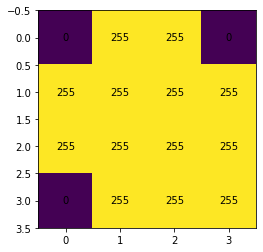

In [23]:
plt.imshow(info)
for i in range(4):
    for j in range(4):
        c = int(info[j,i])
        plt.text(i, j, str(c), va='center', ha='center')


In [64]:
def getTagMask(image, SavePath):
    
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.GaussianBlur(image_gray, (21, 21), 0)


    chosen_contours = findContour(image_gray)
    out_mask = np.zeros_like(image_gray)
    corners = []
    for chosen_contour in chosen_contours:
        corner = cv2.approxPolyDP(chosen_contour, 0.009 * cv2.arcLength(chosen_contour, True), True)
        corners.append(corner.reshape(-1,2))
        cv2.drawContours(image, [chosen_contour], 0, (0,255,0), 3)
        cv2.drawContours(out_mask, [chosen_contour], -1, 1, cv2.FILLED)  

    out_mask_mul = np.dstack((out_mask, out_mask, out_mask))
    detected_april_tag = image * out_mask_mul

    fx, plts = plt.subplots(2,2,figsize = (15,10))
    plts[0][0].imshow(image_gray, cmap = 'gray')
    plts[0][0].set_title('Gray Image')
    plts[0][1].imshow(image)
    plts[0][1].set_title('Outer contour')
    plts[1][0].imshow(np.uint8(out_mask_mul * 255), cmap = 'gray')
    plts[1][0].set_title('Mask')
    plts[1][1].imshow(detected_april_tag)
    plts[1][1].set_title('Mask + image')
    plt.savefig(SavePath + "mask_ar_detect"  + ".jpg")
    return detected_april_tag

In [52]:
def decipherInfoFromTag(info, SavePath):

    dis_info = info.copy()
    while not info[3,3]:
        info = np.rot90(info, 1)

    # print(info)
    id_info = info[1:3, 1:3]
    id_info_flat = np.array([id_info[0,0], id_info[0,1], id_info[1,1], id_info[1,0]])
    tag_id = 0
    tag_id_bin = []
    for i in range(4):
        if(id_info_flat[i]):
            tag_id = tag_id + 2**(3 - i)
            tag_id_bin.append(1)
        else:
            tag_id_bin.append(0)

    fx, plts = plt.subplots(2,2,figsize = (10,10))

    plts[0][0].imshow(dis_info)
    plts[0][0].set_title('Detected Tag')
    for i in range(4):
        for j in range(4):
            c = int(dis_info[j,i])
            plts[0][0].text(i, j, str(c), va='center', ha='center')

    plts[0][1].imshow(info)
    plts[0][1].set_title('Rotation + ID')
    for i in range(4):
        for j in range(4):
            c = int(info[j,i])
            plts[0][1].text(i, j, str(c), va='center', ha='center')

    plts[1][0].imshow(id_info, vmin = 0)
    plts[1][0].set_title('ID')
    for i in range(2):
        for j in range(2):
            c = int(id_info[j,i])
            plts[1][0].text(i, j, str(c), va='center', ha='center')

    plts[1][1].imshow(id_info_flat.reshape(1,4), vmin = 0)
    plts[1][1].set_title('ID flat')
    for i in range(4):
        c = int(id_info_flat[i])
        plts[1][1].text(i, 0, str(c), va='center', ha='center')

    plt.savefig(SavePath + "tag_decipher"  + ".jpg")

    return tag_id, tag_id_bin